<a href="https://colab.research.google.com/github/shadab4150/X_Ray_Covid_19_pnemonia_detection/blob/master/X_ray_pneumonia_bacterial_viral_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> X Ray Types of Pneumonia Detection</h1></center>
<center><h3> Model Image description</h3></center>



<center><img src='https://i.ibb.co/HxvJ6mh/Untitled-document.jpg')</center>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as immg
import numpy as np
from fastai.vision import *
import seaborn as sns;
import gc;

In [0]:
sns.set_style('darkgrid')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/Dataset/XRay_pnemonia_train.zip' -d '/content/x_ray_covid/'

In [0]:
df = pd.read_csv('/content/Xray_pneumonia_data.csv')

In [5]:
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,file_name,image_format,valid
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0128-0001,jpeg,False
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0127-0001,jpeg,False
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0125-0001,jpeg,False
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0122-0001,jpeg,False
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0119-0001,jpeg,False


In [9]:
pne = df.loc[df['Label_1_Virus_category'].isnull()==False];pne.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,file_name,image_format,valid
1341,1341,person101_virus_188.jpeg,Pnemonia,TRAIN,NaN,Virus,person101_virus_188,jpeg,False
1342,1342,person101_virus_187.jpeg,Pnemonia,TRAIN,NaN,Virus,person101_virus_187,jpeg,False
1343,1343,person1019_virus_1708.jpeg,Pnemonia,TRAIN,NaN,Virus,person1019_virus_1708,jpeg,False
1344,1344,person1019_virus_1707.jpeg,Pnemonia,TRAIN,NaN,Virus,person1019_virus_1707,jpeg,False
1345,1345,person1019_bacteria_2950.jpeg,Pnemonia,TRAIN,NaN,bacteria,person1019_bacteria_2950,jpeg,False


In [10]:
pne.shape,df.shape

((4332, 9), (5908, 9))

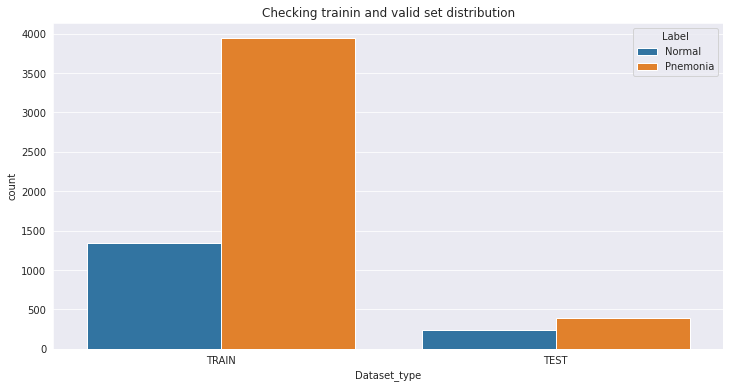

In [23]:
plt.figure(1,figsize=(12,6))
sns.countplot(x=df.Dataset_type,hue=df.Label)
plt.title('Checking training and valid set distribution');

In [69]:
df.valid.value_counts()

False    5284
True      624
Name: valid, dtype: int64

In [0]:
path = Path('/content/')

## First model will be trained for just normal and pneumonia

In [0]:
data_NP = (ImageList.from_df(df,path,folder='x_ray_covid',suffix='.jpg',cols='file_name')
                .split_from_df(col='valid')
                .label_from_df(cols='Label')
                .transform(get_transforms(do_flip=True),size=256)
                .databunch(bs=64)).normalize(imagenet_stats)

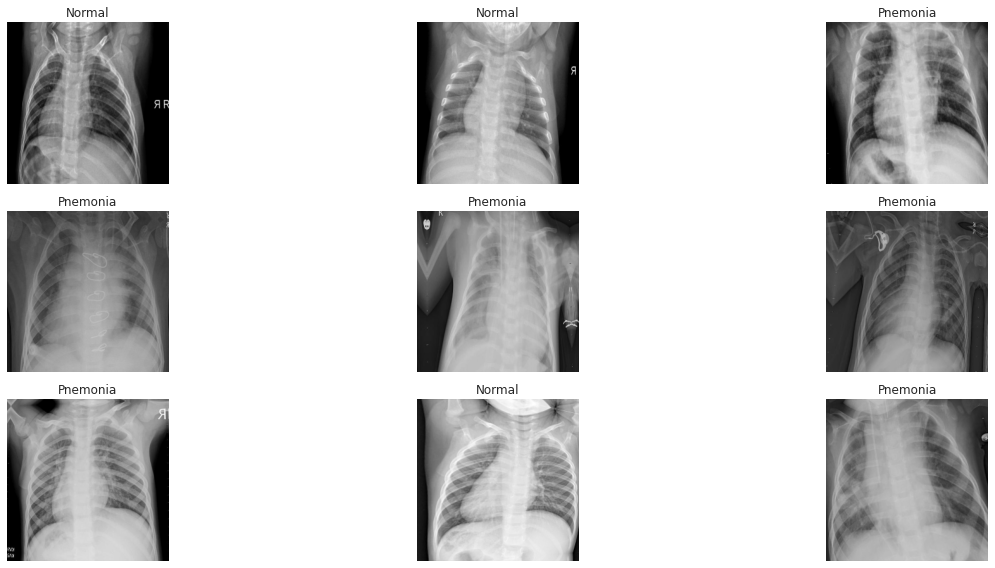

In [27]:
data_NP.show_batch(rows=3,figsize=(20,8))

In [36]:
data_NP.classes,len(data_NP.train_ds),len(data_NP.valid_ds)

(['Normal', 'Pnemonia'], 5284, 624)

## Metrics
* Fbeta
* Recall
* Precision
* Kappa Score

In [0]:
fb = FBeta()
fb.average = 'macro'
rec = Recall()
rec.average = 'macro'
Prc = Precision()
Prc.average = 'macro'
kappa = KappaScore()
kappa.weights = "quadratic"

In [0]:
met = [fb,rec,Prc,kappa]

### Architecture

In [0]:
arch = models.resnet50

In [31]:
learn_np = cnn_learner(data_NP, arch, metrics = met,model_dir='/content/') 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


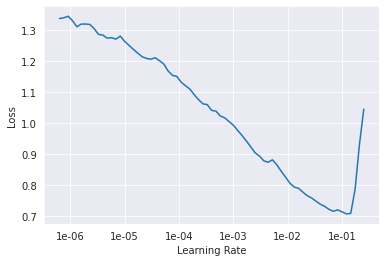

In [33]:
learn_np.lr_find()
learn_np.recorder.plot()

In [44]:
gc.collect()

140

In [37]:
learn_np.fit_one_cycle(6,slice(1e-2,1e-1),moms=0.9)

epoch,train_loss,valid_loss,f_beta,recall,precision,kappa_score,time
0,0.391348,1.731581,0.813688,0.814957,0.809547,0.624047,01:52
1,0.290632,0.496275,0.876665,0.879060,0.869493,0.747262,01:49
2,0.251191,0.587117,0.867018,0.862821,0.902737,0.754667,01:51
3,0.192814,1.133299,0.739965,0.741026,0.873269,0.536122,01:50
4,0.104282,0.551351,0.800654,0.797436,0.892708,0.644444,01:52
5,0.069853,0.394998,0.869974,0.864957,0.925364,0.769369,01:52


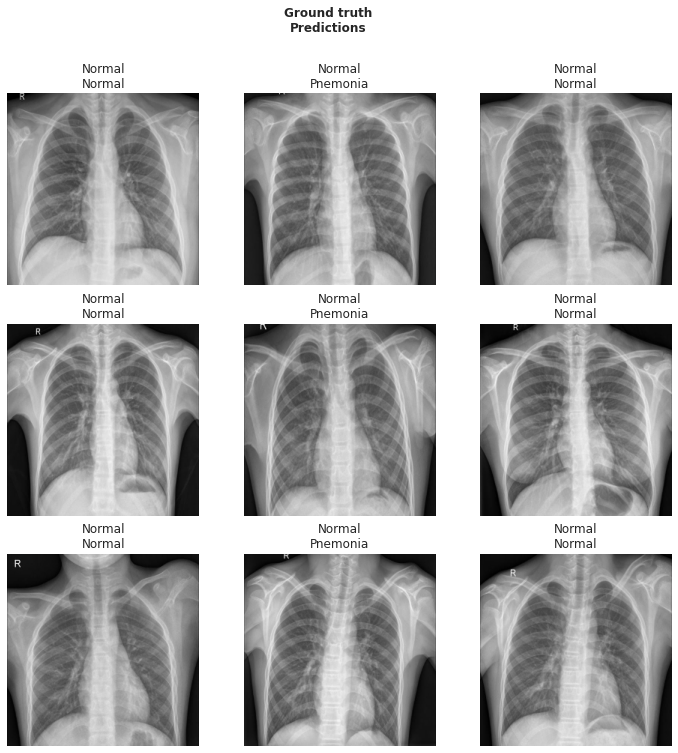

In [47]:
learn_np.show_results(rows=3)

In [48]:
interp = ClassificationInterpretation.from_learner(learn_np)

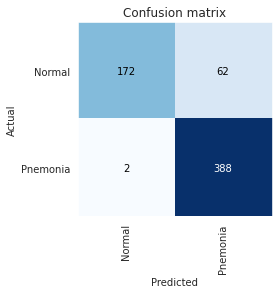

In [49]:
interp.plot_confusion_matrix()

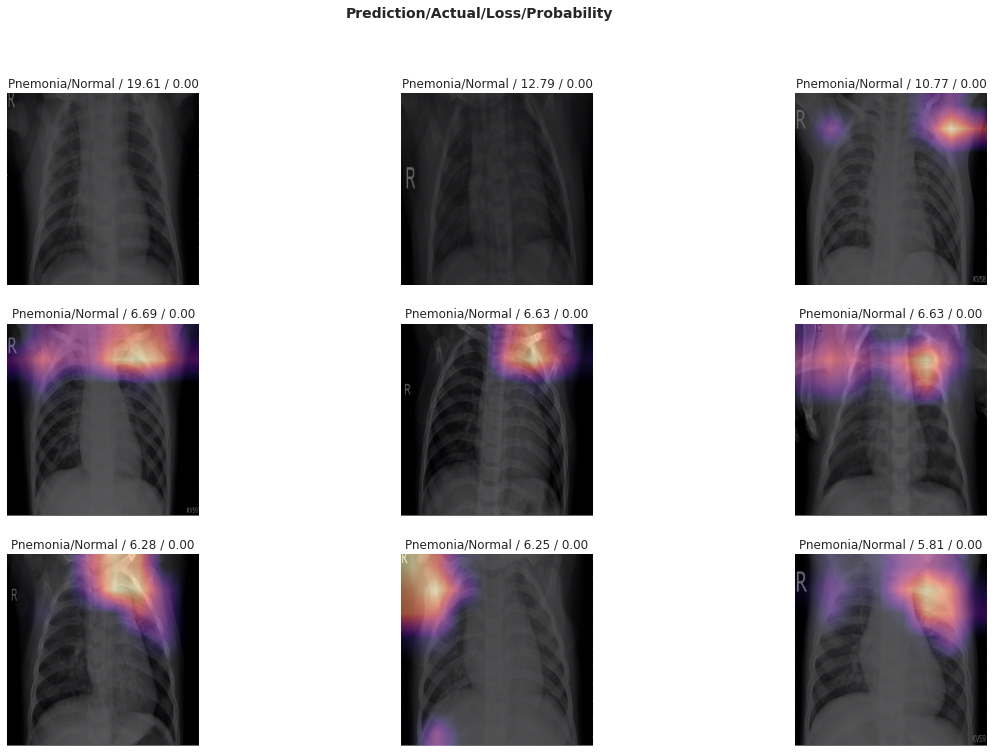

In [54]:
interp.plot_top_losses(k=9,figsize=(20,12),heatmap=True)

### Time to fine tune the model

In [0]:
learn_np.save('model1np')

In [0]:
learn_np.load('model1np');

In [0]:
learn_np.export('nor_pne.pkl')

In [0]:
!cp '/content/nor_pne.pkl' '/content/drive/My Drive/Dataset/'

In [0]:
learn_np.unfreeze()

epoch,train_loss,valid_loss,f_beta,recall,precision,kappa_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


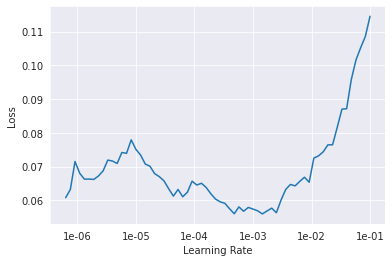

In [61]:
learn_np.lr_find()
learn_np.recorder.plot()

In [62]:
gc.collect()

6415

In [57]:
learn_np.fit_one_cycle(4,slice(1e-5,1e-4))

epoch,train_loss,valid_loss,f_beta,recall,precision,kappa_score,time
0,0.059962,0.402226,0.869974,0.864957,0.925364,0.769369,02:20
1,0.054365,0.387450,0.880652,0.875641,0.930368,0.788341,02:20
2,0.054327,0.439949,0.850554,0.845726,0.916597,0.734787,02:20
3,0.054083,0.398011,0.865681,0.860684,0.923390,0.761733,02:19


In [63]:
learn_np.unfreeze()
#learn_np.freeze_to(-2)
learn_np.fit_one_cycle(4,slice(1e-3/2))

epoch,train_loss,valid_loss,f_beta,recall,precision,kappa_score,time
0,0.064604,0.475637,0.838785,0.834188,0.914217,0.714808,02:19
1,0.061696,0.360353,0.876390,0.871368,0.928355,0.780773,02:19
2,0.048246,0.319706,0.882777,0.877778,0.931381,0.792115,02:20
3,0.039133,0.367694,0.884141,0.879060,0.934285,0.795516,02:19


In [0]:
learn_np.export('x_raynp_fb88.pkl')

In [0]:
!cp '/content/x_raynp_fb88.pkl' '/content/drive/My Drive/Dataset/'

In [67]:
interp = ClassificationInterpretation.from_learner(learn_np)

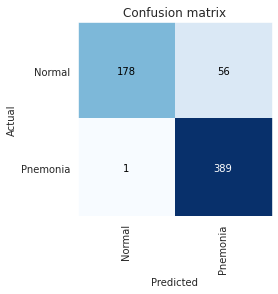

In [68]:
interp.plot_confusion_matrix()

## Now further train model for types of pneumonia

In [70]:
pne.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,file_name,image_format,valid
1341,1341,person101_virus_188.jpeg,Pnemonia,TRAIN,NaN,Virus,person101_virus_188,jpeg,False
1342,1342,person101_virus_187.jpeg,Pnemonia,TRAIN,NaN,Virus,person101_virus_187,jpeg,False
1343,1343,person1019_virus_1708.jpeg,Pnemonia,TRAIN,NaN,Virus,person1019_virus_1708,jpeg,False
1344,1344,person1019_virus_1707.jpeg,Pnemonia,TRAIN,NaN,Virus,person1019_virus_1707,jpeg,False
1345,1345,person1019_bacteria_2950.jpeg,Pnemonia,TRAIN,NaN,bacteria,person1019_bacteria_2950,jpeg,False


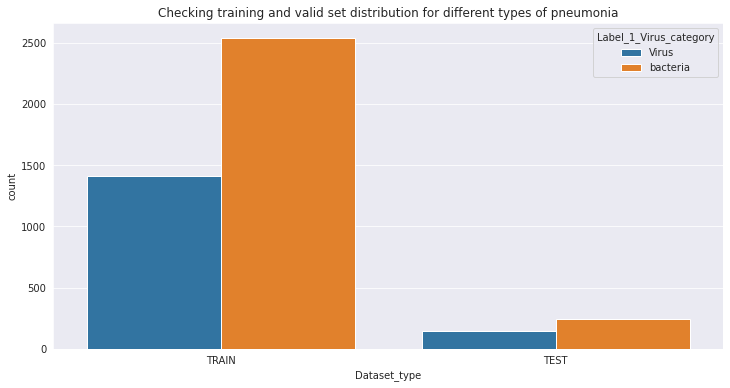

In [74]:
plt.figure(1,figsize=(12,6))
sns.countplot(x=pne.Dataset_type,hue=pne.Label_1_Virus_category)
plt.title('Checking training and valid set distribution for different types of pneumonia');

In [0]:
data_p = (ImageList.from_df(pne,path,folder='x_ray_covid',suffix='.jpg',cols='file_name')
                .split_from_df(col='valid')
                .label_from_df(cols='Label_1_Virus_category')
                .transform(get_transforms(do_flip=True),size=256)
                .databunch(bs=64)).normalize(imagenet_stats)

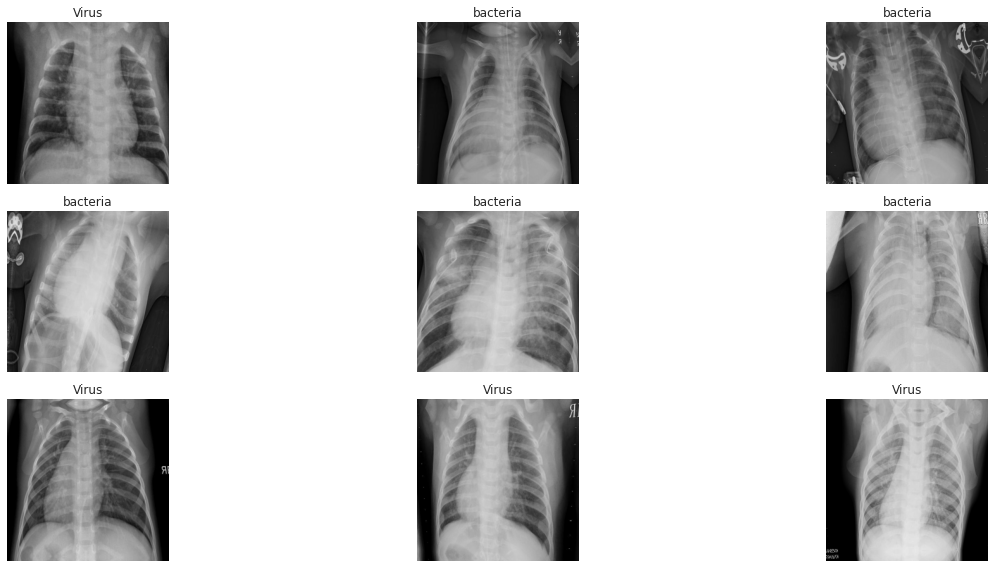

In [77]:
data_p.show_batch(rows=3,figsize=(20,8))

In [78]:
data_p.classes,len(data_p.train_ds),len(data_p.valid_ds)

(['Virus', 'bacteria'], 3942, 390)

* Pneumonia model learner for bacteria and virus

In [0]:
learn_p = cnn_learner(data_p,arch,metrics=met,model_dir='/content/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


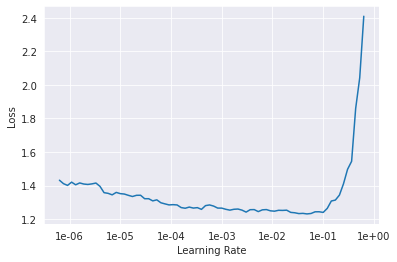

In [80]:
learn_p.lr_find()
learn_p.recorder.plot()

In [83]:
gc.collect()

424

In [84]:
learn_p.fit_one_cycle(6,slice(1e-3,0.055),moms=0.9)

epoch,train_loss,valid_loss,f_beta,recall,precision,kappa_score,time
0,0.976600,1.110036,0.669766,0.702703,0.710893,0.355490,01:26
1,0.958917,0.305181,0.874546,0.870114,0.917065,0.772674,01:24
2,0.662909,0.275885,0.911098,0.910264,0.914804,0.824857,01:24
3,0.550020,0.322565,0.930187,0.928105,0.940908,0.867595,01:22
4,0.488367,0.284547,0.912804,0.910459,0.925573,0.834052,01:21
5,0.446681,0.283819,0.908791,0.905210,0.932759,0.832263,01:21


In [0]:
learn_p.save('modelpne')

In [0]:
learn_p.load('modelpne');

In [0]:
learn_p.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


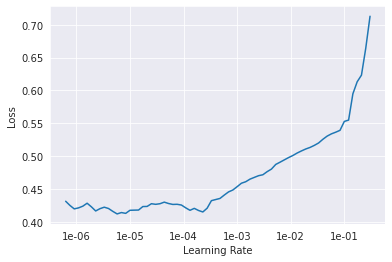

In [95]:
learn_p.lr_find()
learn_p.recorder.plot()

In [99]:
gc.collect()

6486

In [92]:
np.linspace(1e-6,1e-5,5)

array([1.00e-06, 3.25e-06, 5.50e-06, 7.75e-06, 1.00e-05])

In [96]:
learn_p.fit_one_cycle(3,slice(1e-4))

epoch,train_loss,valid_loss,f_beta,recall,precision,kappa_score,time
0,0.438973,0.283062,0.907579,0.904456,0.926950,0.827370,01:45
1,0.418760,0.278588,0.916323,0.913279,0.934637,0.844285,01:44
2,0.414419,0.280588,0.914075,0.911213,0.930883,0.838939,01:44


In [0]:
learn_p.save('modelpne_fb91')

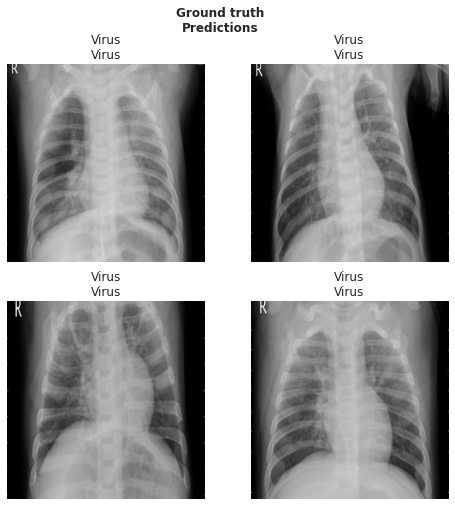

In [147]:
learn_p.show_results(rows=2)

* Interpretation for pneumonia model

In [143]:
interp1 = ClassificationInterpretation.from_learner(learn_p)

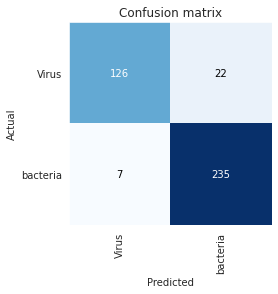

In [144]:
interp1.plot_confusion_matrix()

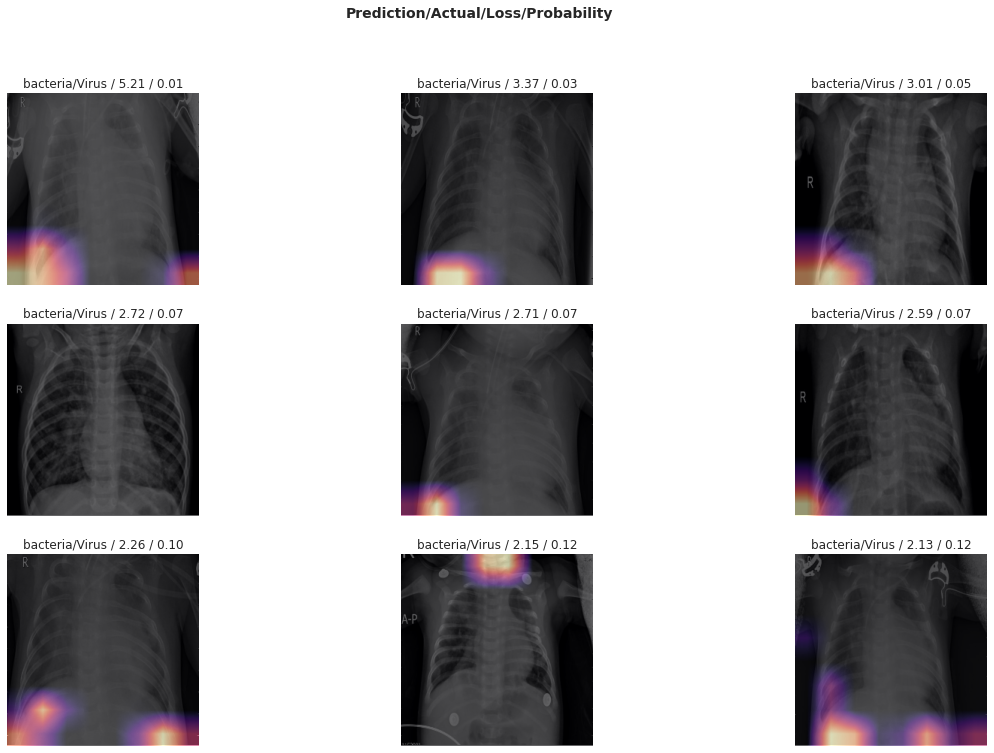

In [145]:
interp1.plot_top_losses(k=9,figsize=(20,12),heatmap=True)

In [0]:
learn_p.export('pne_fb91.pkl')

In [0]:
!cp '/content/pne_fb91.pkl' '/content/drive/My Drive/Dataset/'

In [139]:
df[df['Dataset_type']=='TEST'].sample(n=6)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,file_name,image_format,valid
5586,5611,person141_bacteria_676.jpeg,Pnemonia,TEST,NaN,bacteria,person141_bacteria_676,jpeg,True
5803,5828,person51_virus_105.jpeg,Pnemonia,TEST,NaN,Virus,person51_virus_105,jpeg,True
5594,5619,person139_bacteria_662.jpeg,Pnemonia,TEST,NaN,bacteria,person139_bacteria_662,jpeg,True
5580,5605,person142_bacteria_684.jpeg,Pnemonia,TEST,NaN,bacteria,person142_bacteria_684,jpeg,True
5357,5382,IM-0043-0001.jpeg,Normal,TEST,NaN,NaN,IM-0043-0001,jpeg,True
5462,5487,NORMAL2-IM-0135-0001.jpeg,Normal,TEST,NaN,NaN,NORMAL2-IM-0135-0001,jpeg,True


Pnemonia
bacteria


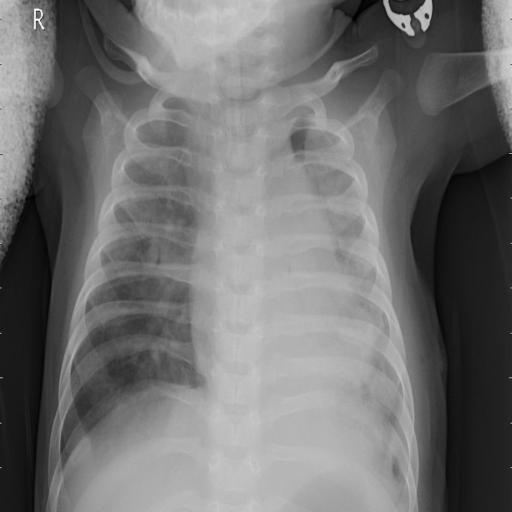

In [141]:
loc = str(path/'x_ray_covid'/df.file_name.iloc[5580])+'.jpg'
img = open_image(loc)
print(data_NP.classes[int(learn_p.predict(img)[0])])
print(data_p.classes[int(learn_p.predict(img)[0])])
img

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');